# Titanic data set Exploration

## Introduction
The Titanic sank off the coast of the North Atlantic after sideswiping an iceberg on April 15, 1912. Only 891 out of the 2000 passengers were identified. This report will expore a data set about those identified passengers.

## Imported modules
These modules will help us plot and construct a pipeline to preprocess the data.

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from pandas.tools.plotting import scatter_matrix
from pandas.plotting import scatter_matrix
from statistics import mean

## Custom Transformers
DataFrameSelector projects the data.

MultiColumnLabelEncoder converts catagorical attributes to numeric.

In [3]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("The DataFrame does not include the columns: %s" % cols_error)

class MultiColumnLabelEncoder:
    def __init__(self, columns = None):
        self.columns = columns # list of column to encode
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        output = X.copy()        
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname, col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)        
        return output
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

## Load data
Data is in the form of a CSV file.

In [6]:
dat_raw = pd.read_csv("C:\\Users\\josem\\Desktop\\train.csv")

## Visualize  missing values
Most missing values are in the cabin attribute followed by the age attribute.

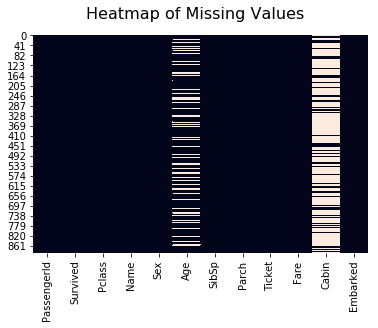

In [7]:
sns.heatmap(dat_raw.isnull(), cbar=False)
plt.suptitle('Heatmap of Missing Values', fontsize=16);

## Record desired numeric and catagorical features
These feautures that will be used to train our learning algorithms.
Also, our catagorical feature pipeline requires objects to be of type string.
We are excluding features that should have nothing to do with your chance of survival (i.e. Name, PassengerID, Ticket).

In [9]:
num_features = ['Age','SibSp','Parch','Fare']
cat_features = ['Survived','Pclass','Sex','Embarked']

dat_raw[cat_features] = dat_raw[cat_features].astype(str)

## Scatter plots and histograms of numeric features
Here is a snapshot of the distrbution of numeric features. These plots also show an overview of the relations between numeric features.

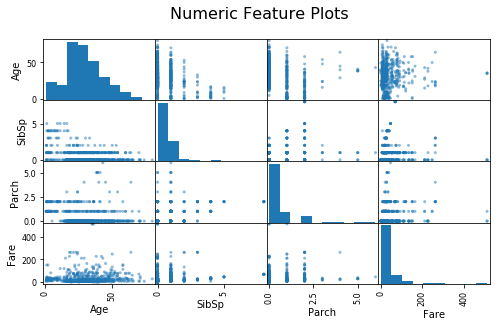

In [10]:
scatter_matrix(dat_raw[num_features], figsize=(8, 4.5))
plt.suptitle('Numeric Feature Plots', fontsize=16);

## Conditional stacked barplots
The distribution of survival appears to be significantly affected by the passengers class.

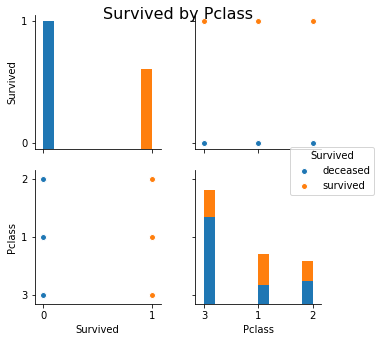

In [32]:
g = sns.pairplot(dat_raw[cat_features], hue='Survived', size=2.4)
plt.suptitle('Survived by Pclass', fontsize=16)
new_labels = ['deceased', 'survived']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l);

## Preprocessing pipelines
One pipeline processes numeric data and the other processes categorical data.

In [12]:
num_pipeline = Pipeline([
  ("selector", DataFrameSelector(num_features)),
  ("remove_nas", Imputer(strategy="median")),
  ("z-scaling", StandardScaler())
])

cat_pipeline = Pipeline([
  ('selector', DataFrameSelector(cat_features)),
  ('labeler', MultiColumnLabelEncoder()),
  ('encoder', OneHotEncoder(sparse = False)),
])

## Preprocess data
Our pipelines' outputs are concatenated to get a final normalized dataframe with no missing values.

In [13]:
dat = pd.DataFrame(np.concatenate((dat_raw[['PassengerId']], 
                      num_pipeline.fit_transform(dat_raw), 
                      cat_pipeline.fit_transform(dat_raw)), 1))

## Assure there are no missing values
After preprocessing, our data has no missing values and catagorical features are now indicator variables.

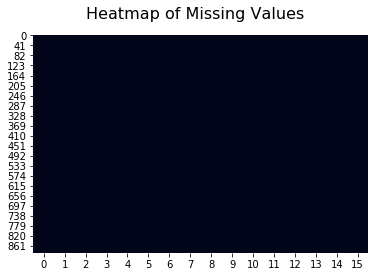

In [14]:
sns.heatmap(dat.isnull(), cbar=False)
plt.suptitle('Heatmap of Missing Values', fontsize=16);

## Visualize processed data
This plot only shows seven of the fifthteen features in the processed data.

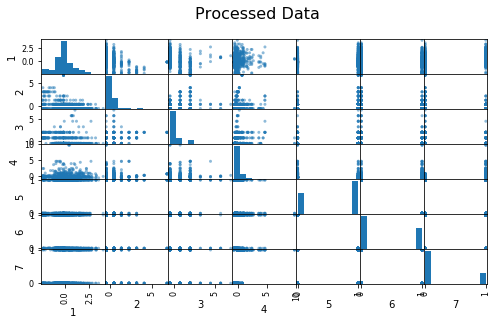

In [53]:
scatter_matrix(dat[[1,2,3,4,5,6,7]], figsize=(8, 4.5))
plt.suptitle('Processed Data', fontsize=16);